In [ ]:
!pip install -U pytorch_transformers

## Импорт библиотек

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


# Для обучения загружаем датасет IMDB Dataset of 50K Movie Reviews

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

!cp gdrive/'My Drive'/'Colab Notebooks'/BERT/'BERT Fine-Tuning Sentence Classification'/'IMDB Dataset.csv' IMDB_Dataset.csv

Mounted at /content/gdrive


In [4]:
BATCH_SIZE = 64 #8
MAX_LEN = 1024
NUM_WORKERS = 4

In [5]:
import pandas as pd
from string import punctuation


labels = {
    'positive': 1,
    'negative': 0
}

dataset = pd.read_csv("./IMDB_Dataset.csv")

dataset['sentiment'] = dataset['sentiment'].apply(lambda x: labels[x])

dataset['review'] = dataset['review'].apply(lambda s: "[CLS] " + s.strip(punctuation) + " [SEP]")
dataset = dataset[dataset['review'].str.len() <= MAX_LEN]

dataset.head()

,review,sentiment
1,[CLS] A wonderful little production. <br /><br...,1
2,[CLS] I thought this was a wonderful way to sp...,1
3,[CLS] Basically there's a family where a littl...,0
5,"[CLS] Probably my all-time favorite movie, a s...",1
6,[CLS] I sure would like to see a resurrection ...,1


# Экспериментально пробуем увеличивать процент тестовых данных и посмотрим как будет изменяться точность модели с уменьшением тестовых примеров.

In [6]:
size_scale = [p/100 for p in range(35, 100, 5)]
print('Перебирать будем следующие размерности тестовой части:', ', '.join(str(s) for s in size_scale) + '.')

Перебирать будем следующие размерности тестовой части: 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95.


In [7]:
from collections import namedtuple

graph_data = namedtuple('Data_for_graph', ['test_size', 'accuracy'])
graph_list = list()

for test_size in size_scale:
  labels = list(dataset['sentiment'])
  sentences = list(dataset['review'])
  
  # Здесь мы задаем первоначальное разбиение на тест и трейн, это место мы и изменяем.
  train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=test_size)
  print(f'\nРазмер трейна {len(train_sentences)}, теста {len(test_sentences)}')

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, max_len=MAX_LEN)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(
      input_ids,
      maxlen=100,
      dtype="long",
#      truncating="post",
      padding="post"
  )
  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
      input_ids, train_gt, 
      random_state=42,
      test_size=0.1
  )

  train_masks, validation_masks, _, _ = train_test_split(
      attention_masks, input_ids,
      random_state=42,
      test_size=0.1
  )

  train_inputs = torch.tensor(train_inputs)
  train_labels = torch.tensor(train_labels)
  train_masks = torch.tensor(train_masks)

  validation_inputs = torch.tensor(validation_inputs)
  validation_labels = torch.tensor(validation_labels)
  validation_masks = torch.tensor(validation_masks)

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(
      train_data,
      sampler=RandomSampler(train_data),
      batch_size=BATCH_SIZE
  )

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_dataloader = DataLoader(
      validation_data,
      sampler=SequentialSampler(validation_data),
      batch_size=BATCH_SIZE
  )

  # Моделька
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
  model.cuda()

  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

  # Обучение
  model.train()
  train_loss = 0
  for step, batch in enumerate(tqdm(train_dataloader)):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      
      optimizer.zero_grad()     
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = loss[0]
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

  del b_input_ids, b_input_mask, b_labels, batch
#  print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

  # Валидация
  model.eval()
  valid_preds, valid_labels = [], []
  for batch in validation_dataloader:   
      batch = tuple(t.to(device) for t in batch)
      
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      logits = logits[0].detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      batch_preds = np.argmax(logits, axis=1)
      batch_labels = label_ids
      valid_preds.extend(batch_preds)
      valid_labels.extend(batch_labels)
  del b_input_ids, b_input_mask, b_labels, batch

  accuracy = accuracy_score(valid_labels, valid_preds) * 100
  train_size = 1 - test_size
  print(f"Процент правильных предсказаний при обучении на размере {train_size:.2f}: {accuracy:.2f}%")
  graph_list.append(graph_data(train_size, accuracy))
  model.to('cpu')


Размер трейна 17154, теста 9238


  0%|          | 0/242 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
100%|██████████| 242/242 [02:35<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.65: 91.14%

Размер трейна 15835, теста 10557


100%|██████████| 223/223 [02:23<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.60: 90.40%

Размер трейна 14515, теста 11877


100%|██████████| 205/205 [02:11<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.55: 88.15%

Размер трейна 13196, теста 13196


100%|██████████| 186/186 [01:59<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.50: 89.24%

Размер трейна 11876, теста 14516


100%|██████████| 167/167 [01:47<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.45: 89.31%

Размер трейна 10556, теста 15836


100%|██████████| 149/149 [01:35<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.40: 88.26%

Размер трейна 9237, теста 17155


100%|██████████| 130/130 [01:23<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.35: 89.72%

Размер трейна 7917, теста 18475


100%|██████████| 112/112 [01:11<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.30: 88.38%

Размер трейна 6598, теста 19794


100%|██████████| 93/93 [00:59<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.25: 89.70%

Размер трейна 5278, теста 21114


100%|██████████| 75/75 [00:47<00:00,  1.57it/s]


Процент правильных предсказаний при обучении на размере 0.20: 88.45%

Размер трейна 3958, теста 22434


100%|██████████| 56/56 [00:35<00:00,  1.56it/s]


Процент правильных предсказаний при обучении на размере 0.15: 88.13%

Размер трейна 2639, теста 23753


100%|██████████| 38/38 [00:23<00:00,  1.59it/s]


Процент правильных предсказаний при обучении на размере 0.10: 79.17%

Размер трейна 1319, теста 25073


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Процент правильных предсказаний при обучении на размере 0.05: 77.27%


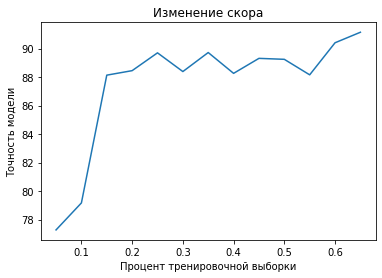

In [8]:
scores = [g.accuracy for g in graph_list]
sizes = [g.test_size for g in graph_list]

plt.plot(sizes, scores)
plt.title('Изменение скора')
plt.xlabel('Процент тренировочной выборки')
plt.ylabel('Точность модели')
plt.show()

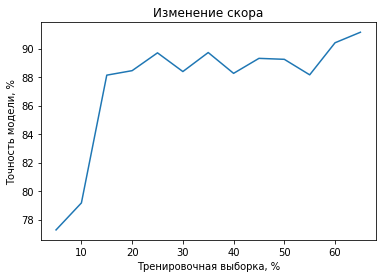

In [10]:
scores = [g.accuracy for g in graph_list]
sizes = [g.test_size*100 for g in graph_list]

plt.plot(sizes, scores)
plt.title('Изменение скора')
plt.xlabel('Тренировочная выборка, %')
plt.ylabel('Точность модели, %')
plt.show()

Как мы видим в общем точность колеблется примерно на одном уровне, хотя чем больше данных тем выше конечная точность. А резкое падение начинается с размером менее 30 процентов от исходных данных